# **Music Genre Classification** - Francisco Madruga Nº 55956

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
from IPython.core.display import HTML
import librosa
import librosa.display
import csv
import math
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, minmax_scale
import tensorflow.keras as keras
from scipy.stats import kurtosis, skew
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

O dataset [GTZAN Genre Collection](http://marsyas.info/downloads/datasets.html) é composto por 1000 ficheiros de áudio com cerca 30 segundos de duração. Neste dataset existem 10 classes (10 géneros músicais) e cada um deles contém 100 ficheiros.

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/AAA_Project/dataset'

In [ ]:
data = {
    'Genre': [],
    'Name': [],
    'Path': []
}

for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)
    for audio_file in os.listdir(genre_path):
        audio_file_path = os.path.join(genre_path, audio_file)
        data['Genre'].append(genre)
        data['Name'].append(os.path.basename(audio_file_path))
        data['Path'].append(audio_file_path)
df = pd.DataFrame(data)
df

,Genre,Name,Path
0,blues,blues.00003.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
1,blues,blues.00001.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
2,blues,blues.00006.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
3,blues,blues.00004.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
4,blues,blues.00000.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
...,...,...,...
995,classical,classical.00080.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
996,classical,classical.00098.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
997,classical,classical.00096.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...
998,classical,classical.00099.wav,/content/drive/MyDrive/Colab Notebooks/AAA_Pro...


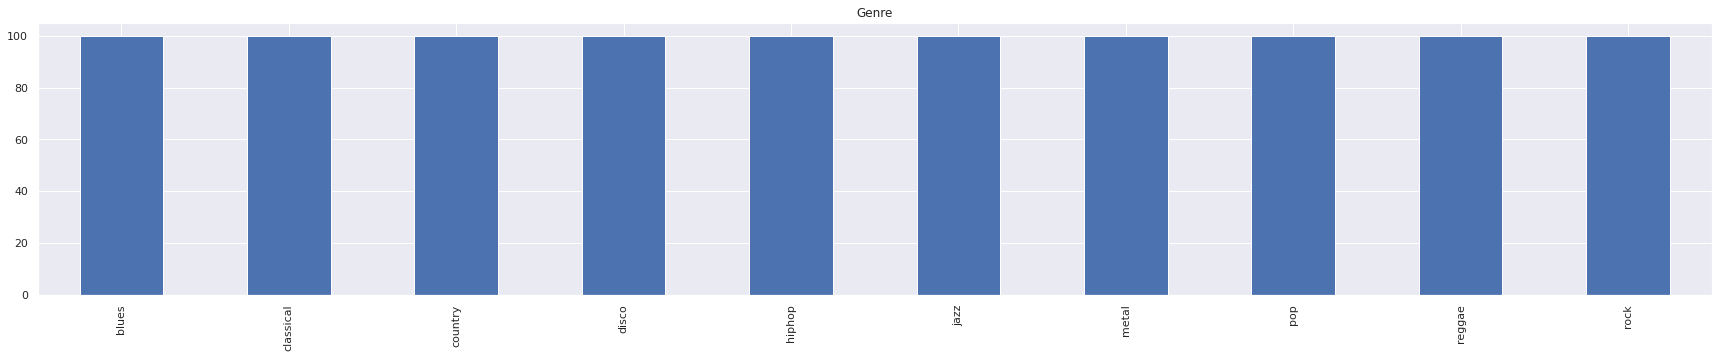

In [ ]:
pd.value_counts(df['Genre']).sort_index().plot.bar(figsize=(30, 5), title='Genre')

## Dataset samples

In [ ]:
for genre in df['Genre'].unique():
    sample = df[df['Genre'] == genre].sample()
    display(HTML(sample.to_html()))
    display(ipd.Audio(sample['Path'].values[0]))

Output hidden; open in https://colab.research.google.com to view.

# Feature extraction

In [ ]:
def extract_mfcc(dataset_path,
                     pickle_file_path,
                     duration,
                     verbose=1,
                     n_mfcc=13,
                     n_fft=2048,
                     hop_length=512,
                     num_segments=5,
                     sample_rate=22050):
    
    data = {
        'mapping': [],
        'X': [],
        'y': []
    }

    samples_per_track = sample_rate * duration
    num_samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    genres_num = len(os.listdir(dataset_path))

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            if verbose > 0:
                print('\nGenre {}/{}: {}'.format(i, genres_num, semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data['X'].append(mfcc.tolist())
                        data['y'].append(i - 1)
                        if verbose > 1:
                            print('Genre {}/{}: {}, segment = {}'.format(i, genres_num, file_path, s))
    with open(pickle_file_path, 'wb') as f:
        pickle.dump(data, f)
    if verbose > 1:
        print('DONE')

In [ ]:
def extract_features(dataset_path,
                     csv_path,
                     duration,
                     verbose=1,
                     n_mfcc=20,
                     n_fft=2048,
                     hop_length=512,
                     num_segments=5,
                     sample_rate=22050):
    
    extracted_features = []
    samples_per_track = sample_rate * duration
    num_samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    genres_num = len(os.listdir(dataset_path))

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            if verbose > 0:
                print('\nGenre {}/{}: {}'.format(i, genres_num, semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    segment_signal = signal[start_sample:finish_sample]
                    mfcc = librosa.feature.mfcc(segment_signal,
                                            sr=sr,
                                            n_fft=n_fft,
                                            n_mfcc=n_mfcc,
                                            hop_length=hop_length)
                    
                    if len(mfcc.T) == expected_num_mfcc_vectors_per_segment:
                        features = {
                            'spectral_centroid': librosa.feature.spectral_centroid(segment_signal, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                            'chroma_stft': librosa.feature.chroma_stft(segment_signal, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                            'flux': librosa.onset.onset_strength(y=segment_signal, sr=sr).ravel(),
                            'rmse': librosa.feature.rms(segment_signal, frame_length=n_fft, hop_length=hop_length).ravel(),
                            'zero_crossing_rate': librosa.feature.zero_crossing_rate(segment_signal, frame_length=n_fft, hop_length=hop_length).ravel(),
                            'spectral_contrast': librosa.feature.spectral_contrast(segment_signal, sr=sr).ravel(),
                            'spectral_bandwidth': librosa.feature.spectral_bandwidth(segment_signal, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                            'spectral_flatness': librosa.feature.spectral_flatness(segment_signal, n_fft=n_fft, hop_length=hop_length).ravel(),
                            'spectral_rolloff': librosa.feature.spectral_rolloff(segment_signal, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                            'harmony': librosa.feature.tempogram(segment_signal, sr=sr, hop_length=hop_length).ravel()
                            }

                        for index, mfcc_value in enumerate(mfcc):
                            features['mfcc_{}'.format(index)] = mfcc_value.ravel()

                        result = {
                            'filename': f,
                            'segment': s,
                            'label': semantic_label,
                        }

                        for k, v in features.items():
                            result['{}_max'.format(k)] = np.max(v)
                            result['{}_min'.format(k)] = np.min(v)
                            result['{}_mean'.format(k)] = np.mean(v)
                            result['{}_std'.format(k)] = np.std(v)
                            result['{}_kurtosis'.format(k)] = kurtosis(v)
                            result['{}_skew'.format(k)] = skew(v)

                        result['tempo'] = librosa.beat.tempo(y=segment_signal, sr=sr, hop_length=hop_length)[0]

                        extracted_features.append(result)
                        if verbose > 1:
                            print('Genre {}/{}: {}, segment {}'.format(i, genres_num, file_path, s))

    df = pd.DataFrame(data=extracted_features)
    df.to_csv(csv_path, index=False)
    if verbose > 1:
        print('DONE')

In [ ]:
answer = input('This proccess takes to much time, are you sure you want to procced: y/n\n')
if answer.lower() == 'y' or answer.lower() == 'yes':
    segments = [1, 5, 10, 15, 20, 25, 30]
    n_mfccs = [13, 15, 20, 22, 25, 28, 30]

    for segment in segments:
        for n_mfcc in n_mfccs:
            csv_path = '/content/drive/MyDrive/Colab Notebooks/AAA_Project/data_' + str(segment) + 'segment_' + str(n_mfcc) + 'mfcc.csv'
            print('Segment = ', segment, 'n_mfcc =', n_mfcc)
            extract_features(dataset_path, csv_path, 30, n_mfcc=n_mfcc, num_segments=segment, verbose=1)
            pickle_file_path = '/content/drive/MyDrive/Colab Notebooks/AAA_Project/data_' + str(segment) + 'segment_' + str(n_mfcc) + 'mfcc.pkl'
            print('Segment = ', segment, 'n_mfcc =', n_mfcc)
            extract_mfcc(dataset_path, pickle_file_path, 30, verbose=1, n_mfcc=n_mfcc, num_segments=segment)

This proccess takes to much time, are you sure you want to procced: y/n
n


In [ ]:
def load_data(dataset_path):
    pickle_off = open (dataset_path, "rb")
    data = pickle.load(pickle_off)
    X = np.array(data['X'])
    y = np.array(data['y'])
    return X, y

In [ ]:
def split_dataset(X, y, test_size, validation_size=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if validation_size == 0:
        return X_train, X_test, y_train, y_test
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def plot_history(history, metric, label=None):
    fig, axs = plt.subplots(2, figsize=(16,9))
    if label:
        fig.suptitle(label)
    axs[0].plot(history.history[metric], label='Training ' + metric)
    axs[0].plot(history.history['val_' + metric], label='Validation ' + metric)
    axs[0].set_ylabel(metric)
    axs[0].legend(loc='lower right')
    axs[0].set_title('Training and Validation ' + metric)

    axs[1].plot(history.history["loss"], label='Training loss')
    axs[1].plot(history.history["val_loss"], label='Validation loss')
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title('Training and Validation Loss')

    plt.show()

In [ ]:
def show_scores(results, models_labels, detailed=True):
    scores = {}
    for model_label in models_labels:
        for metric in results[model_label]:
            if metric not in ['model', 'history']:
                metric_mean_col_name = 'Mean ' + metric
                metric_std_col_name = 'Standard deviation ' + metric
                if metric_mean_col_name in scores:
                    scores[metric_mean_col_name].append(np.average(np.array(results[model_label][metric])))
                else:
                    scores[metric_mean_col_name] = [np.average(np.array(results[model_label][metric]))]
                if metric_std_col_name in scores:
                    scores[metric_std_col_name].append(np.std(np.array(results[model_label][metric])))
                else:
                    scores[metric_std_col_name] = [np.std(np.array(results[model_label][metric]))]
                if detailed:
                    for i, score in enumerate(results[model_label][metric]):
                        metric_col_name = metric + ' ' + str(i + 1)
                        if metric_col_name in scores:
                            scores[metric_col_name].append(score)
                        else:
                            scores[metric_col_name] = [score]
    score_df = pd.DataFrame(scores, index=models_labels)
    score_df = score_df.sort_values(by='Mean test accuracy', ascending=False)
    return score_df

In [ ]:
pickle_file_path = '/content/drive/MyDrive/Colab Notebooks/AAA_Project/data_10segment_20mfcc.pkl'

In [ ]:
results = {}
models_labels = []
times_to_run = 5

In [ ]:
X, y = load_data(pickle_file_path)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, 0.25, 0.2)

## Multilayer perceptron (MLP)

In [ ]:
model_label = 'Multilayer perceptron'
models_labels.append(model_label)
results[model_label] = {
    'model': [],
    'history': [],
    'test accuracy': [],
    'train accuracy': [],
    'val accuracy': [],
    'test loss': [],
    'train loss': [],
    'val loss': []
}

for i in range(times_to_run):
    print('\nTraining', model_label, (i + 1))
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(65, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    epochs = 85
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    results[model_label]['model'].append(model)
    results[model_label]['history'].append(history)
    results[model_label]['test accuracy'].append(test_acc)
    results[model_label]['train accuracy'].append(train_acc)
    results[model_label]['val accuracy'].append(val_acc)
    results[model_label]['test loss'].append(test_loss)
    results[model_label]['train loss'].append(train_loss)
    results[model_label]['val loss'].append(val_loss)


Training Multilayer perceptron 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1331712   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                16705     
_________________________________________________________________
dropout_2 (Dropout)   

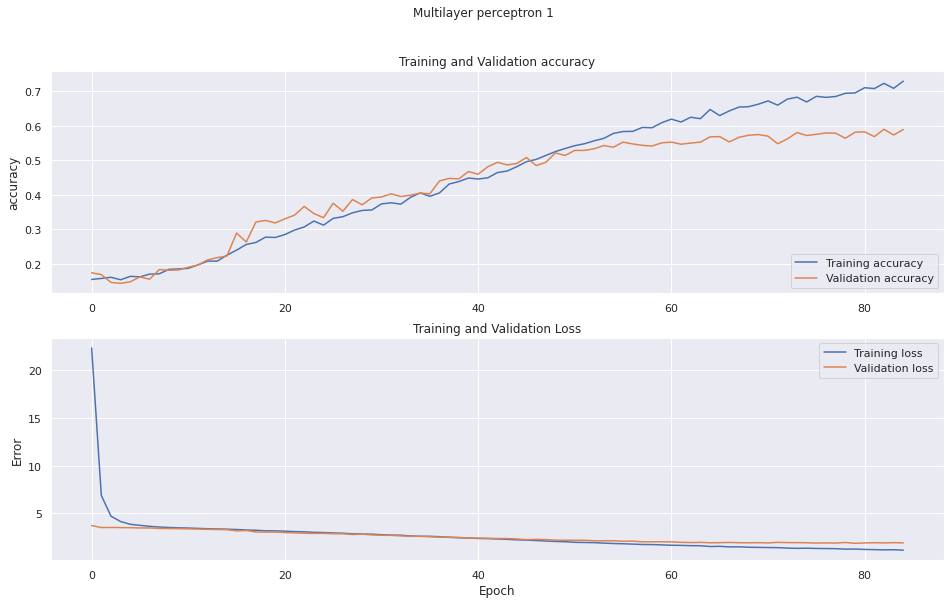

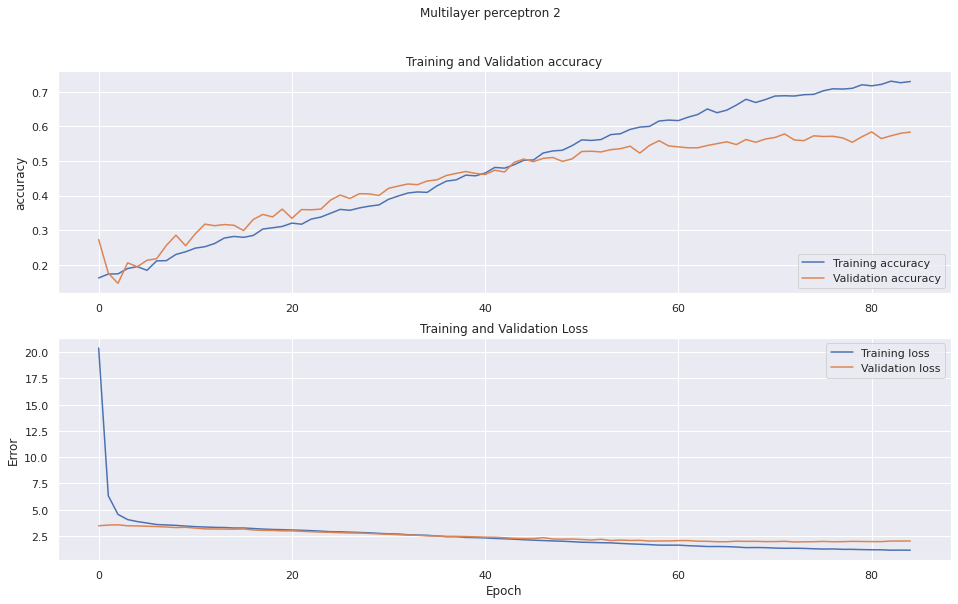

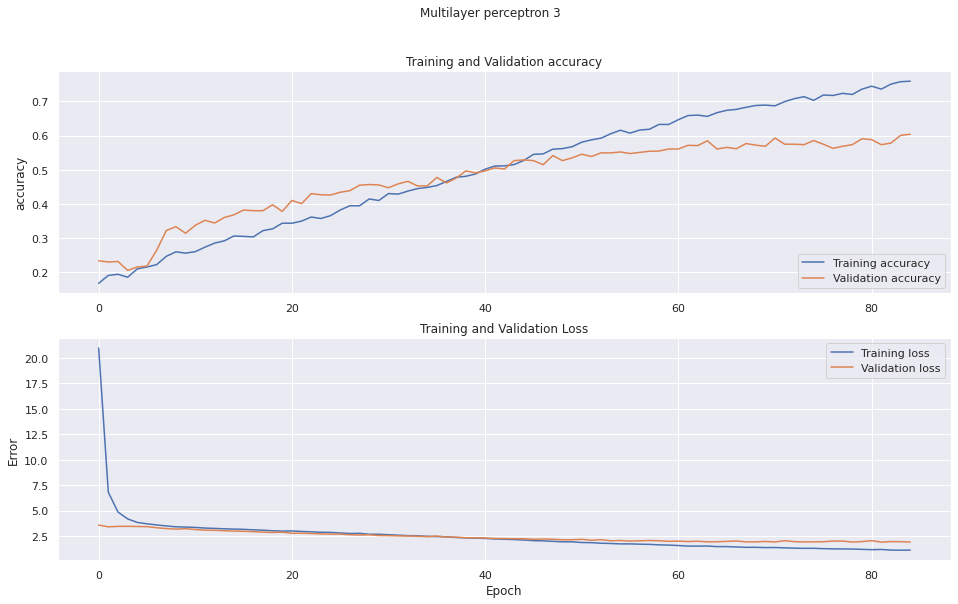

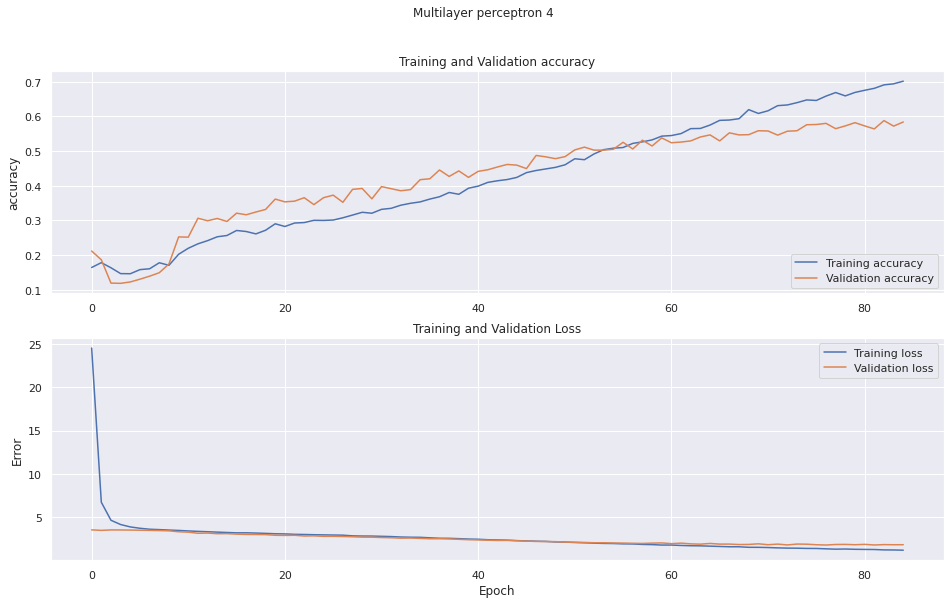

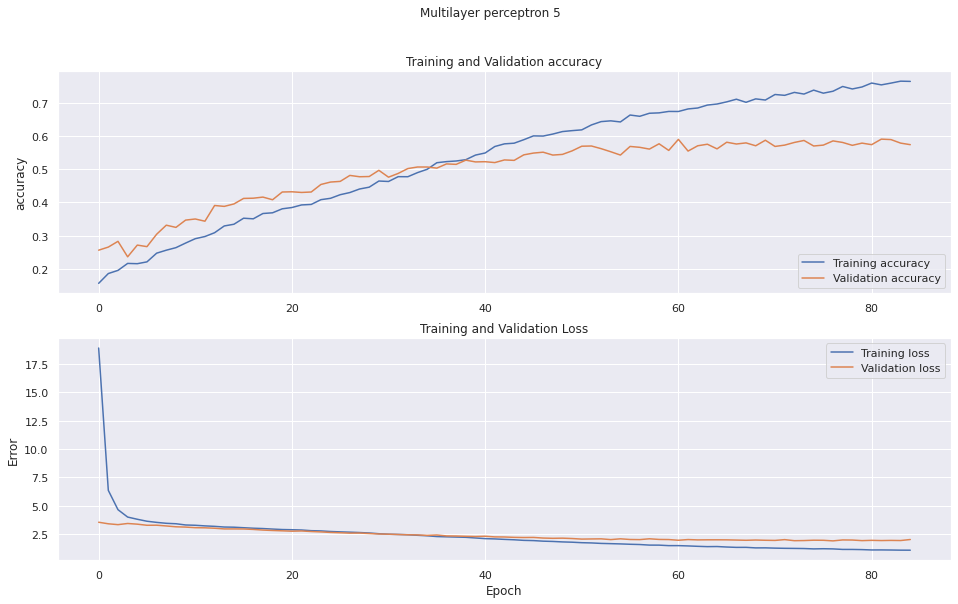

In [ ]:
for i, history in enumerate(results[model_label]['history']):
    plot_history(history, 'accuracy', model_label + ' ' + str(i + 1))
    print()

In [ ]:
show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Multilayer perceptron,0.57551,0.007385,0.577031,0.561825,0.580632,0.583033,0.57503,0.851426,0.017627,0.843088,0.841254,0.879773,0.830248,0.862765,0.586933,0.009858,0.589333,0.583333,0.604,0.584,0.574,1.948836,0.033294,1.921141,2.000426,1.935584,1.912842,1.974186,0.859746,0.051345,0.882525,0.848437,0.806972,0.947095,0.813703,1.941028,0.058515,1.917092,2.003606,1.90697,1.863037,2.014434


## Convolutional neural network (CNN)

In [ ]:
def prepare_samples_for_CNN(X_train, X_val, X_test):
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_val, X_test

In [ ]:
X, y = load_data(pickle_file_path)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, 0.25, 0.2)
X_train, X_val, X_test = prepare_samples_for_CNN(X_train, X_val, X_test)

In [ ]:
model_label = 'Convolutional neural network'
models_labels.append(model_label)
results[model_label] = {
    'model': [],
    'history': [],
    'test accuracy': [],
    'train accuracy': [],
    'val accuracy': [],
    'test loss': [],
    'train loss': [],
    'val loss': []
}

for i in range(times_to_run):
    print('\nTraining', model_label, (i + 1))
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (2, 2), activation='relu'),
        keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    epochs = 35
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    results[model_label]['model'].append(model)
    results[model_label]['history'].append(history)
    results[model_label]['test accuracy'].append(test_acc)
    results[model_label]['train accuracy'].append(train_acc)
    results[model_label]['val accuracy'].append(val_acc)
    results[model_label]['test loss'].append(test_loss)
    results[model_label]['train loss'].append(train_loss)
    results[model_label]['val loss'].append(val_loss)


Training Convolutional neural network 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 18, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 9, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 9, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 7, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 4, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 4, 32)         128       
_________________________________________________________________
conv2d_2 (Con

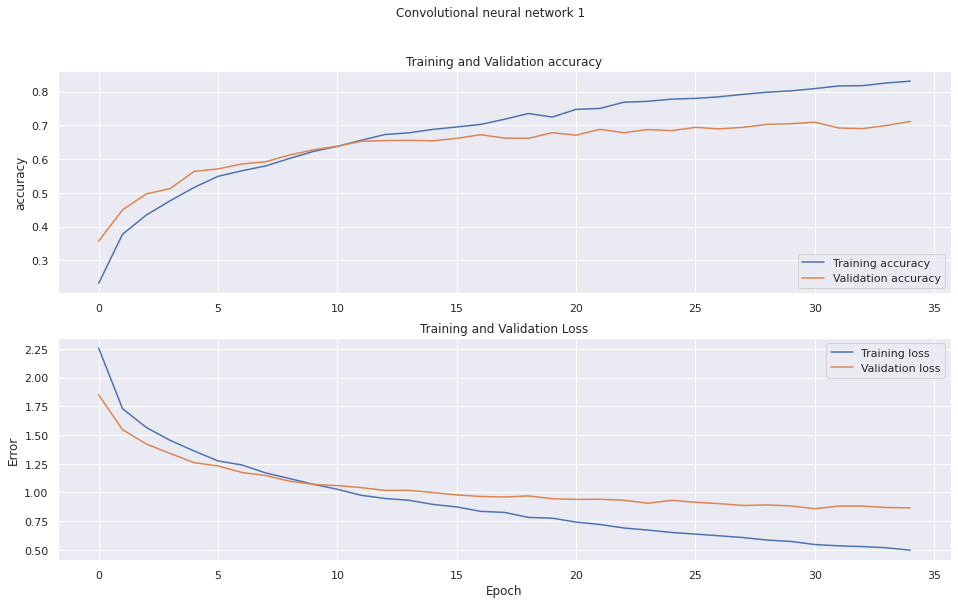

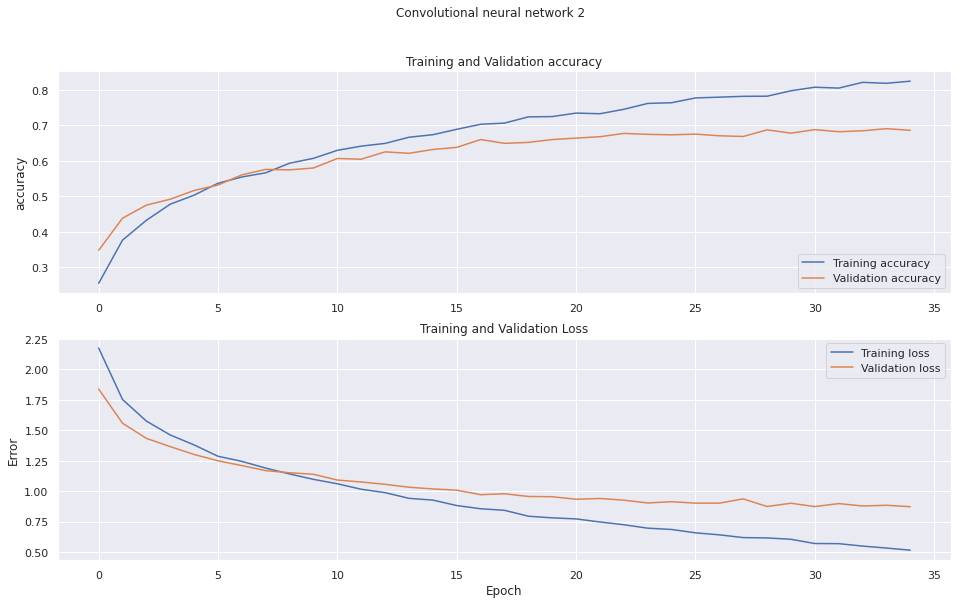

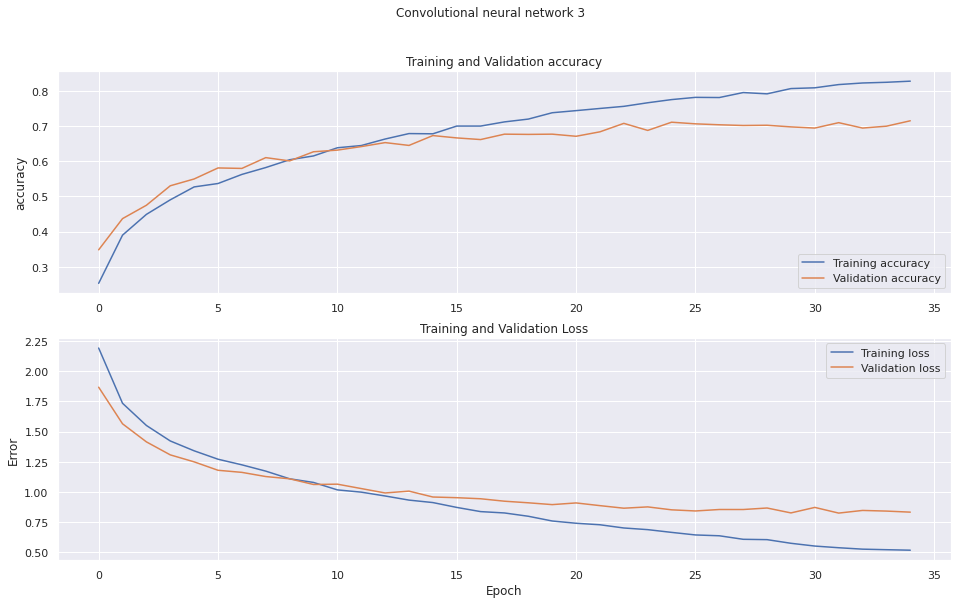

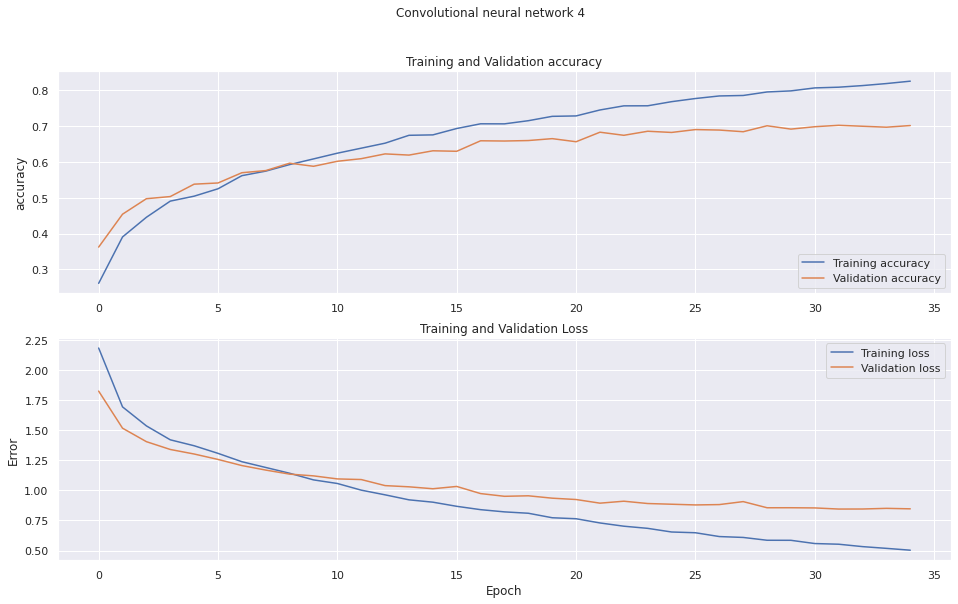

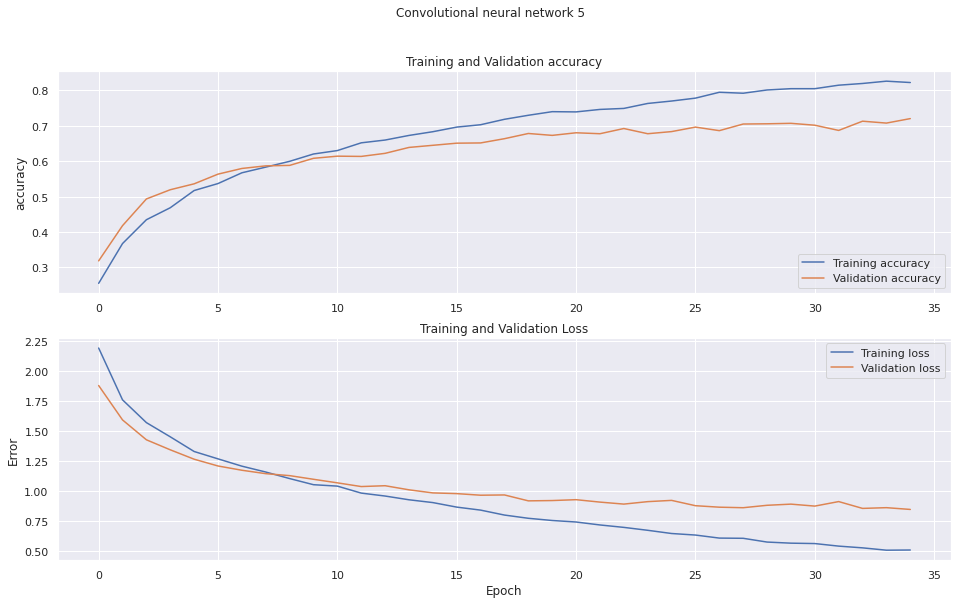

In [ ]:
for i, history in enumerate(results[model_label]['history']):
    plot_history(history, 'accuracy', model_label + ' ' + str(i + 1))
    print()

In [ ]:
show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Convolutional neural network,0.721729,0.009465,0.723089,0.703481,0.729092,0.729092,0.72389,0.922328,0.005442,0.928964,0.91329,0.92096,0.921627,0.926797,0.706667,0.012169,0.711333,0.685333,0.714667,0.702,0.72,0.80648,0.021763,0.799935,0.847397,0.78209,0.799705,0.803274,0.303421,0.011922,0.288922,0.323536,0.305367,0.305274,0.294006,0.852064,0.014735,0.864132,0.871756,0.829576,0.846097,0.84876


## Recurrent neural network (RNN)
### Long short term memory (LSTM)

In [ ]:
X, y = load_data(pickle_file_path)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, 0.25, 0.2)

In [ ]:
model_label = 'Long short term memory'
models_labels.append(model_label)
results[model_label] = {
    'model': [],
    'history': [],
    'test accuracy': [],
    'train accuracy': [],
    'val accuracy': [],
    'test loss': [],
    'train loss': [],
    'val loss': []
}

for i in range(times_to_run):
    print('\nTraining', model_label, (i + 1))
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        keras.layers.LSTM(64),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    epochs = 40
    batch_size = 32
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    results[model_label]['model'].append(model)
    results[model_label]['history'].append(history)
    results[model_label]['test accuracy'].append(test_acc)
    results[model_label]['train accuracy'].append(train_acc)
    results[model_label]['val accuracy'].append(val_acc)
    results[model_label]['test loss'].append(test_loss)
    results[model_label]['train loss'].append(train_loss)
    results[model_label]['val loss'].append(val_loss)


Training Long short term memory 1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           21760     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 59,594
Trainable params: 59,594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
188/188 [==============================] - 6s 17ms/step - loss: 2.262

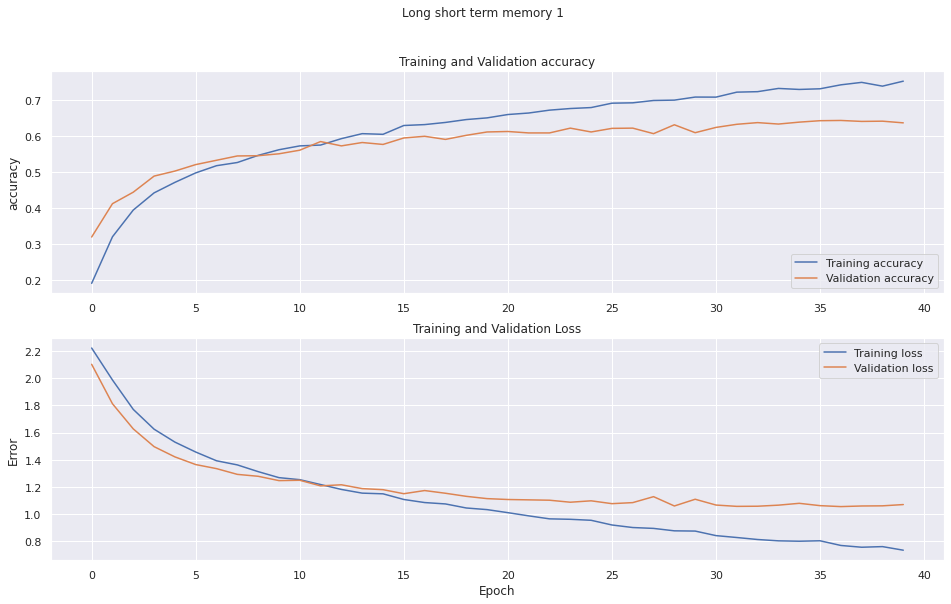

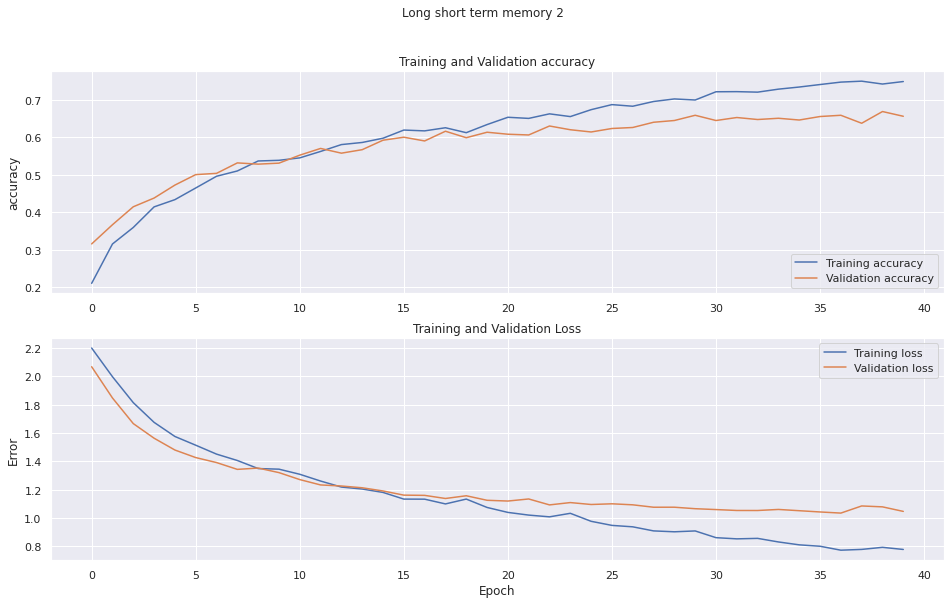

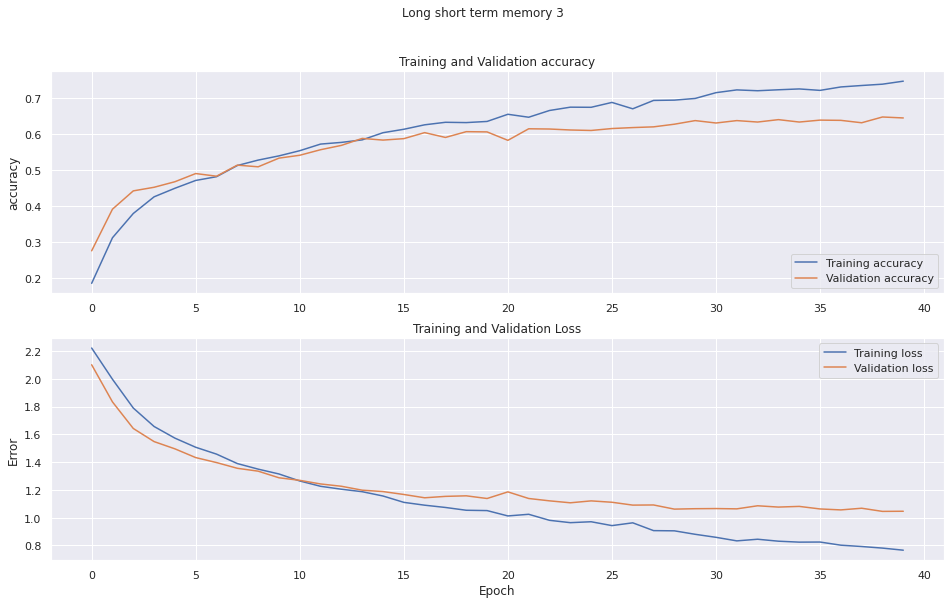

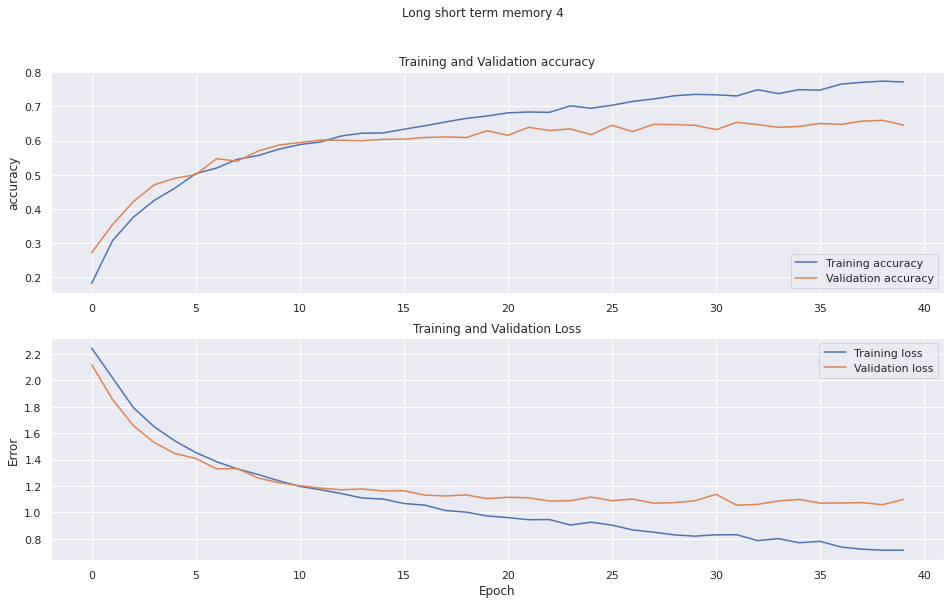

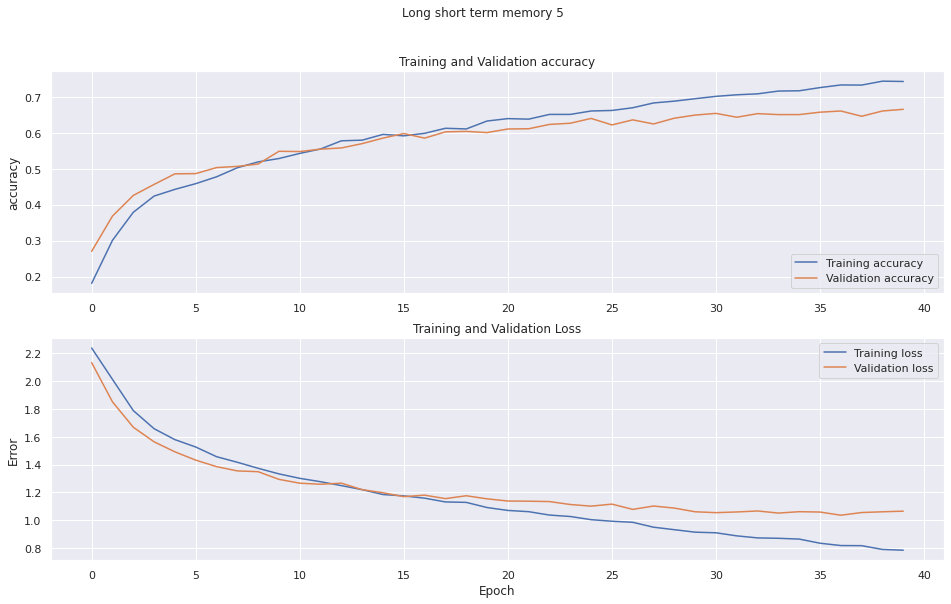

In [ ]:
for i, history in enumerate(results[model_label]['history']):
    plot_history(history, 'accuracy', model_label + ' ' + str(i + 1))
    print()

In [ ]:
show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Long short term memory,0.634974,0.007569,0.641457,0.646259,0.631853,0.627851,0.627451,0.775088,0.005164,0.771386,0.783892,0.777555,0.77322,0.769385,0.6496,0.009867,0.636667,0.656667,0.644667,0.645333,0.664667,1.132066,0.026037,1.118956,1.097611,1.121378,1.171676,1.150707,0.683079,0.009939,0.675527,0.671168,0.686573,0.68225,0.699876,1.065515,0.019019,1.070508,1.046617,1.046358,1.098061,1.066031


## Result using mfcc

In [ ]:
show_scores(results, models_labels)

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Convolutional neural network,0.721729,0.009465,0.723089,0.703481,0.729092,0.729092,0.723890,0.922328,0.005442,0.928964,0.913290,0.920960,0.921627,0.926797,0.706667,0.012169,0.711333,0.685333,0.714667,0.702000,0.720000,0.806480,0.021763,0.799935,0.847397,0.782090,0.799705,0.803274,0.303421,0.011922,0.288922,0.323536,0.305367,0.305274,0.294006,0.852064,0.014735,0.864132,0.871756,0.829576,0.846097,0.848760
Long short term memory,0.634974,0.007569,0.641457,0.646259,0.631853,0.627851,0.627451,0.775088,0.005164,0.771386,0.783892,0.777555,0.773220,0.769385,0.649600,0.009867,0.636667,0.656667,0.644667,0.645333,0.664667,1.132066,0.026037,1.118956,1.097611,1.121378,1.171676,1.150707,0.683079,0.009939,0.675527,0.671168,0.686573,0.682250,0.699876,1.065515,0.019019,1.070508,1.046617,1.046358,1.098061,1.066031
Multilayer perceptron,0.575510,0.007385,0.577031,0.561825,0.580632,0.583033,0.575030,0.851426,0.017627,0.843088,0.841254,0.879773,0.830248,0.862765,0.586933,0.009858,0.589333,0.583333,0.604000,0.584000,0.574000,1.948836,0.033294,1.921141,2.000426,1.935584,1.912842,1.974186,0.859746,0.051345,0.882525,0.848437,0.806972,0.947095,0.813703,1.941028,0.058515,1.917092,2.003606,1.906970,1.863037,2.014434


In [ ]:
show_scores(results, models_labels, False)

,Mean test accuracy,Standard deviation test accuracy,Mean train accuracy,Standard deviation train accuracy,Mean val accuracy,Standard deviation val accuracy,Mean test loss,Standard deviation test loss,Mean train loss,Standard deviation train loss,Mean val loss,Standard deviation val loss
Convolutional neural network,0.721729,0.009465,0.922328,0.005442,0.706667,0.012169,0.806480,0.021763,0.303421,0.011922,0.852064,0.014735
Long short term memory,0.634974,0.007569,0.775088,0.005164,0.649600,0.009867,1.132066,0.026037,0.683079,0.009939,1.065515,0.019019
Multilayer perceptron,0.575510,0.007385,0.851426,0.017627,0.586933,0.009858,1.948836,0.033294,0.859746,0.051345,1.941028,0.058515


# Using more features

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/AAA_Project/data_10segment_20mfcc.csv'

In [ ]:
df = pd.read_csv(csv_path)
df

,filename,segment,label,spectral_centroid_max,spectral_centroid_min,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_kurtosis,spectral_centroid_skew,chroma_stft_max,chroma_stft_min,chroma_stft_mean,chroma_stft_std,chroma_stft_kurtosis,chroma_stft_skew,flux_max,flux_min,flux_mean,flux_std,flux_kurtosis,flux_skew,rmse_max,rmse_min,rmse_mean,rmse_std,rmse_kurtosis,rmse_skew,zero_crossing_rate_max,zero_crossing_rate_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_kurtosis,zero_crossing_rate_skew,spectral_contrast_max,spectral_contrast_min,spectral_contrast_mean,spectral_contrast_std,spectral_contrast_kurtosis,spectral_contrast_skew,spectral_bandwidth_max,...,mfcc_13_std,mfcc_13_kurtosis,mfcc_13_skew,mfcc_14_max,mfcc_14_min,mfcc_14_mean,mfcc_14_std,mfcc_14_kurtosis,mfcc_14_skew,mfcc_15_max,mfcc_15_min,mfcc_15_mean,mfcc_15_std,mfcc_15_kurtosis,mfcc_15_skew,mfcc_16_max,mfcc_16_min,mfcc_16_mean,mfcc_16_std,mfcc_16_kurtosis,mfcc_16_skew,mfcc_17_max,mfcc_17_min,mfcc_17_mean,mfcc_17_std,mfcc_17_kurtosis,mfcc_17_skew,mfcc_18_max,mfcc_18_min,mfcc_18_mean,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
0,blues.00003.wav,0,blues,1930.249420,450.878497,860.102393,293.931869,1.255598,1.004031,1.0,0.007798,0.369220,0.317108,-0.704686,0.798822,10.985868,0.0,1.117187,1.788923,10.058750,3.019654,0.383715,0.018764,0.140007,0.093954,-0.484046,0.752595,0.055664,0.005859,0.024707,0.014777,-1.142829,0.587823,51.917072,7.119713,20.951401,7.329326,-0.121464,0.755461,2197.142019,...,4.951379,-0.060440,0.163368,14.011157,-12.472734,-0.856941,5.582450,-0.515506,0.423259,15.472240,-11.838092,1.799606,5.402627,-0.154058,0.518108,18.006485,-7.477188,1.955676,4.923675,1.525134,1.102910,13.678989,-6.202806,3.055818,3.807157,0.301996,0.293292,10.863269,-12.571098,-0.123177,5.014997,-0.228895,-0.405437,11.639397,-15.252482,-4.151962,5.227437,0.486460,0.372904,184.570312
1,blues.00003.wav,1,blues,1890.058457,316.951261,941.452934,380.764654,-0.712333,0.371619,1.0,0.012923,0.391710,0.312520,-0.835151,0.675513,12.368990,0.0,1.296324,2.221530,10.727726,3.196909,0.296086,0.013736,0.146981,0.083870,-1.224945,-0.092642,0.083984,0.006836,0.031982,0.017871,-0.212560,0.556918,47.681593,5.654186,21.277800,7.438618,-0.051643,0.728291,2170.114660,...,7.218275,-0.877025,-0.306957,13.600521,-13.509110,-2.314024,6.119695,-0.444094,0.495239,17.475494,-15.437303,-0.080863,6.301831,0.241869,0.492831,13.321411,-11.763702,-0.943168,4.764770,0.174684,0.214269,13.659277,-8.531294,1.282212,4.583932,-0.528358,0.015222,16.383783,-10.893981,2.770220,5.440075,-0.327831,-0.111118,16.066835,-10.153143,-0.842844,6.121224,0.167610,0.900957,184.570312
2,blues.00003.wav,2,blues,1713.939958,498.011768,898.756632,305.979211,-0.160651,0.739278,1.0,0.009867,0.421759,0.306522,-0.896329,0.601477,8.933214,0.0,1.234111,1.773321,4.896646,2.361148,0.315457,0.016304,0.138577,0.084460,-0.843502,0.332085,0.070312,0.007324,0.028084,0.015651,-0.076861,0.867739,57.601470,6.507547,21.168573,7.233160,0.467186,0.863455,2145.608901,...,6.081512,0.449986,0.239206,6.623774,-25.531063,-8.556034,4.971272,1.569609,-0.172839,7.797153,-18.502991,-2.661010,4.673620,0.734631,-0.475558,15.583389,-18.215527,0.867326,6.683907,-0.077625,-0.354113,15.109039,-11.126469,4.180612,5.972533,-0.664470,-0.428992,10.853803,-7.888752,2.254115,4.513114,-0.790499,-0.061818,6.940906,-11.332888,-1.582498,4.127835,-0.547018,-0.285066,172.265625
3,blues.00003.wav,3,blues,2012.977134,395.379061,1123.802547,450.115678,-1.162131,0.457665,1.0,0.029953,0.444026,0.294308,-0.881788,0.575748,9.418895,0.0,1.171487,1.663844,8.712039,2.965777,0.294543,0.015307,0.129585,0.070169,-0.584712,0.518684,0.069336,0.007324,0.034075,0.016104,-0.857257,0.392689,55.104249,6.255401,21.047653,8.218542,0.259733,0.981747,2550.317813,...,4.473490,-0.310406,-0.194751,10.346027,-17.842091,-1.160015,5.504780,0.259027,-0.117019,12.781368,-12.067052,1.015339,5.2712

In [ ]:
def encode_labels(df, column):
    label_index = dict()
    index_label = dict()
    for i, x in enumerate(df[column].unique()):
        label_index[x] = i
        index_label[i] = x
    df[column] = [label_index[l] for l in df[column]]
    return df, label_index, index_label

In [ ]:
df, label_index, index_label = encode_labels(df, 'label')

In [ ]:
df = df.drop(columns=['filename', 'segment'])
df

,label,spectral_centroid_max,spectral_centroid_min,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_kurtosis,spectral_centroid_skew,chroma_stft_max,chroma_stft_min,chroma_stft_mean,chroma_stft_std,chroma_stft_kurtosis,chroma_stft_skew,flux_max,flux_min,flux_mean,flux_std,flux_kurtosis,flux_skew,rmse_max,rmse_min,rmse_mean,rmse_std,rmse_kurtosis,rmse_skew,zero_crossing_rate_max,zero_crossing_rate_min,zero_crossing_rate_mean,zero_crossing_rate_std,zero_crossing_rate_kurtosis,zero_crossing_rate_skew,spectral_contrast_max,spectral_contrast_min,spectral_contrast_mean,spectral_contrast_std,spectral_contrast_kurtosis,spectral_contrast_skew,spectral_bandwidth_max,spectral_bandwidth_min,spectral_bandwidth_mean,...,mfcc_13_std,mfcc_13_kurtosis,mfcc_13_skew,mfcc_14_max,mfcc_14_min,mfcc_14_mean,mfcc_14_std,mfcc_14_kurtosis,mfcc_14_skew,mfcc_15_max,mfcc_15_min,mfcc_15_mean,mfcc_15_std,mfcc_15_kurtosis,mfcc_15_skew,mfcc_16_max,mfcc_16_min,mfcc_16_mean,mfcc_16_std,mfcc_16_kurtosis,mfcc_16_skew,mfcc_17_max,mfcc_17_min,mfcc_17_mean,mfcc_17_std,mfcc_17_kurtosis,mfcc_17_skew,mfcc_18_max,mfcc_18_min,mfcc_18_mean,mfcc_18_std,mfcc_18_kurtosis,mfcc_18_skew,mfcc_19_max,mfcc_19_min,mfcc_19_mean,mfcc_19_std,mfcc_19_kurtosis,mfcc_19_skew,tempo
0,0,1930.249420,450.878497,860.102393,293.931869,1.255598,1.004031,1.0,0.007798,0.369220,0.317108,-0.704686,0.798822,10.985868,0.0,1.117187,1.788923,10.058750,3.019654,0.383715,0.018764,0.140007,0.093954,-0.484046,0.752595,0.055664,0.005859,0.024707,0.014777,-1.142829,0.587823,51.917072,7.119713,20.951401,7.329326,-0.121464,0.755461,2197.142019,818.980089,1375.015519,...,4.951379,-0.060440,0.163368,14.011157,-12.472734,-0.856941,5.582450,-0.515506,0.423259,15.472240,-11.838092,1.799606,5.402627,-0.154058,0.518108,18.006485,-7.477188,1.955676,4.923675,1.525134,1.102910,13.678989,-6.202806,3.055818,3.807157,0.301996,0.293292,10.863269,-12.571098,-0.123177,5.014997,-0.228895,-0.405437,11.639397,-15.252482,-4.151962,5.227437,0.486460,0.372904,184.570312
1,0,1890.058457,316.951261,941.452934,380.764654,-0.712333,0.371619,1.0,0.012923,0.391710,0.312520,-0.835151,0.675513,12.368990,0.0,1.296324,2.221530,10.727726,3.196909,0.296086,0.013736,0.146981,0.083870,-1.224945,-0.092642,0.083984,0.006836,0.031982,0.017871,-0.212560,0.556918,47.681593,5.654186,21.277800,7.438618,-0.051643,0.728291,2170.114660,787.028181,1393.290628,...,7.218275,-0.877025,-0.306957,13.600521,-13.509110,-2.314024,6.119695,-0.444094,0.495239,17.475494,-15.437303,-0.080863,6.301831,0.241869,0.492831,13.321411,-11.763702,-0.943168,4.764770,0.174684,0.214269,13.659277,-8.531294,1.282212,4.583932,-0.528358,0.015222,16.383783,-10.893981,2.770220,5.440075,-0.327831,-0.111118,16.066835,-10.153143,-0.842844,6.121224,0.167610,0.900957,184.570312
2,0,1713.939958,498.011768,898.756632,305.979211,-0.160651,0.739278,1.0,0.009867,0.421759,0.306522,-0.896329,0.601477,8.933214,0.0,1.234111,1.773321,4.896646,2.361148,0.315457,0.016304,0.138577,0.084460,-0.843502,0.332085,0.070312,0.007324,0.028084,0.015651,-0.076861,0.867739,57.601470,6.507547,21.168573,7.233160,0.467186,0.863455,2145.608901,661.152140,1365.500464,...,6.081512,0.449986,0.239206,6.623774,-25.531063,-8.556034,4.971272,1.569609,-0.172839,7.797153,-18.502991,-2.661010,4.673620,0.734631,-0.475558,15.583389,-18.215527,0.867326,6.683907,-0.077625,-0.354113,15.109039,-11.126469,4.180612,5.972533,-0.664470,-0.428992,10.853803,-7.888752,2.254115,4.513114,-0.790499,-0.061818,6.940906,-11.332888,-1.582498,4.127835,-0.547018,-0.285066,172.265625
3,0,2012.977134,395.379061,1123.802547,450.115678,-1.162131,0.457665,1.0,0.029953,0.444026,0.294308,-0.881788,0.575748,9.418895,0.0,1.171487,1.663844,8.712039,2.965777,0.294543,0.015307,0.129585,0.070169,-0.584712,0.518684,0.069336,0.007324,0.034075,0.016104,-0.857257,0.392689,55.104249,6.255401,21.047653,8.218542,0.259733,0.981747,2550.317813,745.901523,1665.910637,...,4.473490,-0.310406,-0.194751,10.346027,-17.842091,-1.160015,5.504780,0.259027,-0.117019,12

# Multilayer perceptron (MLP)

In [ ]:
target = 'label'
X = df.drop(target, axis=1).values
y = df[target].values
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, 0.25, 0.2)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [ ]:
model_label = 'Multilayer perceptron (more features)'
models_labels.append(model_label)
results[model_label] = {
    'model': [],
    'history': [],
    'test accuracy': [],
    'train accuracy': [],
    'val accuracy': [],
    'test loss': [],
    'train loss': [],
    'val loss': []
}

for i in range(times_to_run):
    print('\nTraining', model_label, (i + 1))
    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(65, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    epochs = 85
    batch_size = 32
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    results[model_label]['model'].append(model)
    results[model_label]['history'].append(history)
    results[model_label]['test accuracy'].append(test_acc)
    results[model_label]['train accuracy'].append(train_acc)
    results[model_label]['val accuracy'].append(val_acc)
    results[model_label]['test loss'].append(test_loss)
    results[model_label]['train loss'].append(train_loss)
    results[model_label]['val loss'].append(val_loss)


Training Multilayer perceptron (more features) 1
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512)               93184     
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 65)                16705     
_________________________________________________________________
dropout_27 (Dropout)         (None, 65)                0         
_________________________________________________________________
den

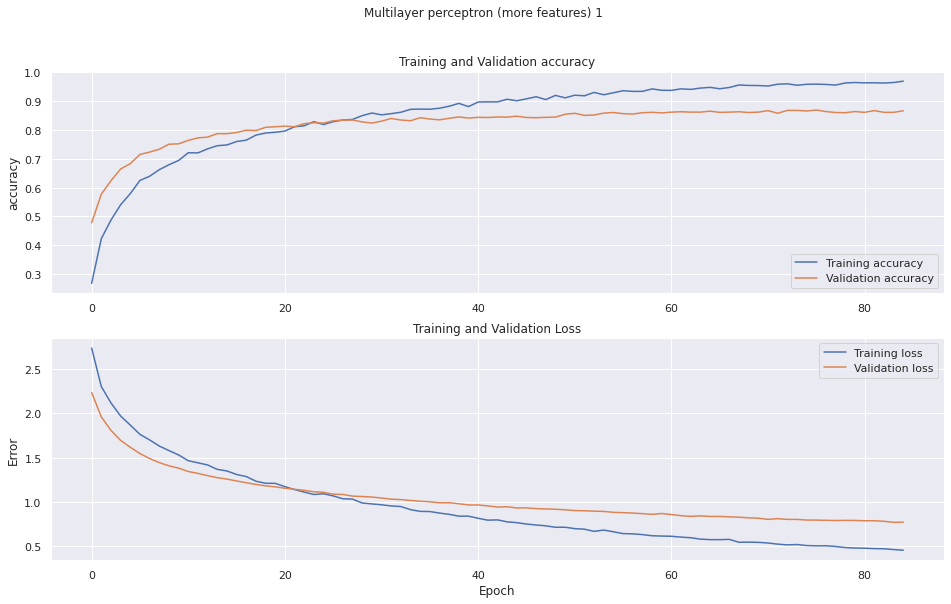

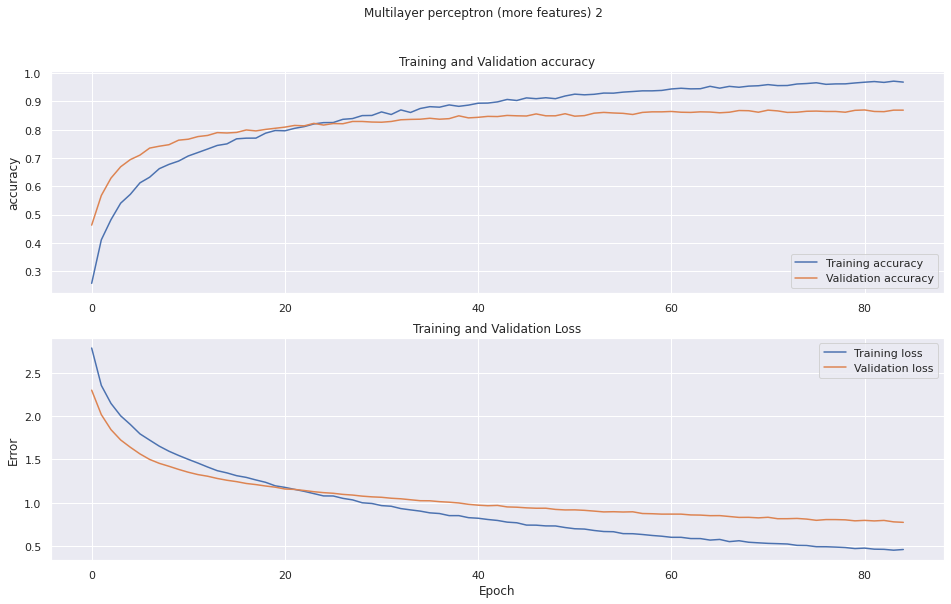

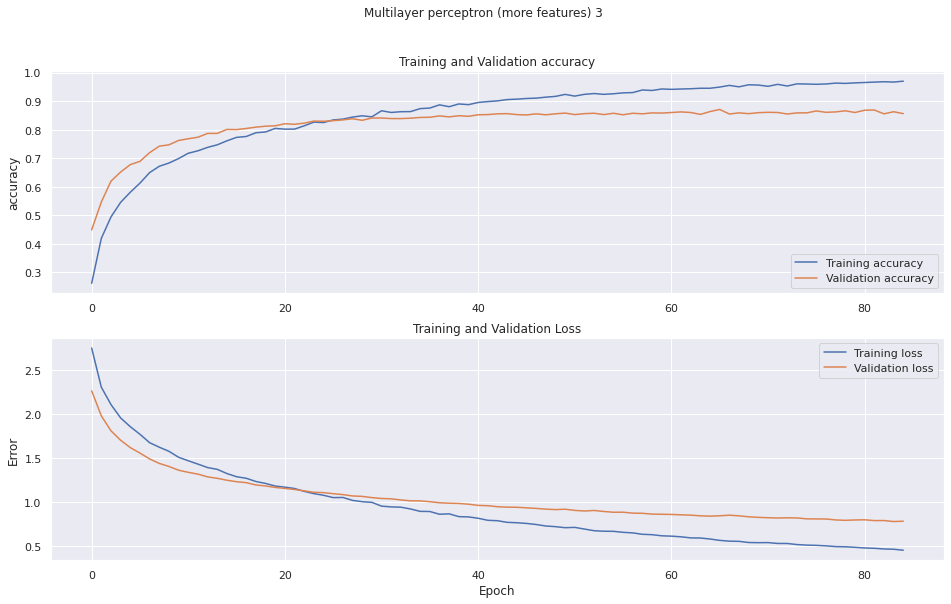

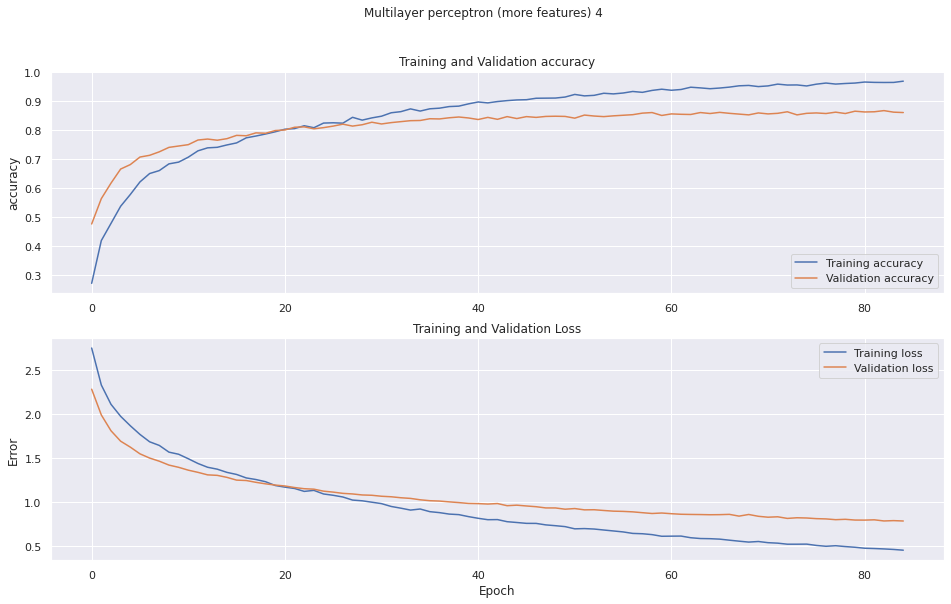

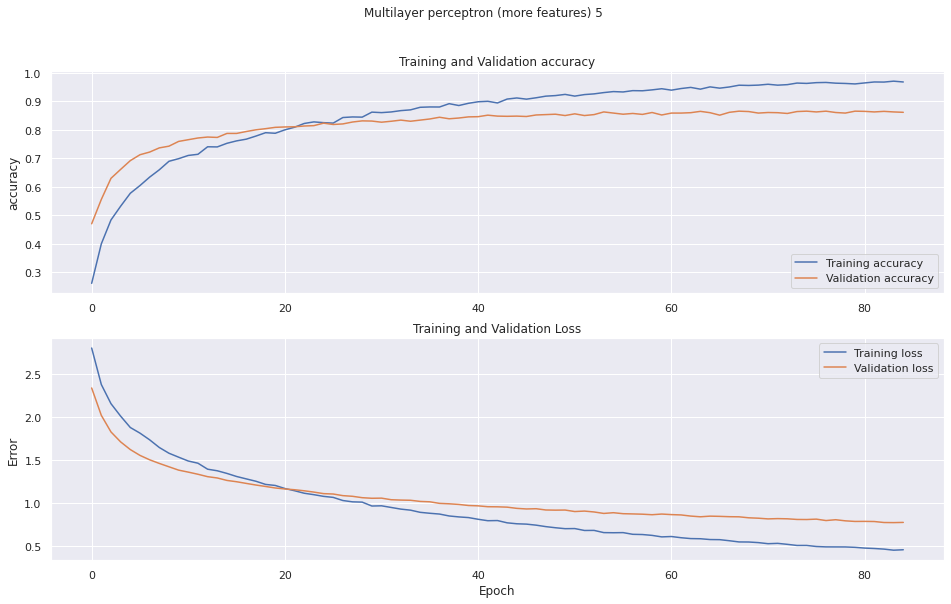

In [ ]:
for i, history in enumerate(results[model_label]['history']):
    plot_history(history, 'accuracy', model_label + ' ' + str(i + 1))
    print()

In [ ]:
show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Multilayer perceptron (more features),0.864506,0.002825,0.859944,0.865146,0.865946,0.863145,0.868347,0.998132,0.000245,0.998333,0.997999,0.997999,0.997832,0.998499,0.8628,0.00447,0.866667,0.868667,0.856,0.861333,0.861333,0.810528,0.008608,0.819055,0.800835,0.822491,0.806229,0.80403,0.365433,0.001512,0.363025,0.366179,0.365561,0.367594,0.364808,0.77967,0.005691,0.772359,0.776426,0.782931,0.788827,0.777806


In [ ]:
def cross_validation_model(X, y, model, splits):
    scores = {
        'test accuracy': [],
        'train accuracy': []
    }
    models = []

    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        model.fit(X_train, y_train)
        models.append(model)
        y_pred = model.predict(X_test).round()
        y_pred_train = model.predict(X_train).round()
        accuracy_test = accuracy_score(y_test,  y_pred)
        accuracy_train = accuracy_score(y_train,  y_pred_train)
        scores['test accuracy'].append(accuracy_test)
        scores['train accuracy'].append(accuracy_train)
    return models, scores

In [ ]:
target = 'label'
X = df.drop(target, axis=1).values
y = df[target].values

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## K-nereast neighbors

In [ ]:
model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
models, scores = cross_validation_model(X, y, model, 2)

model_label = 'K-nereast neighbors'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

NameError: ignored

## Random forest

In [ ]:
model = RandomForestClassifier(criterion='gini', max_depth=9, random_state=42, n_jobs=-1)
models, scores = cross_validation_model(X, y, model, times_to_run)

model_label = 'Random forest'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Random forest,0.777912,0.007298,0.7695,0.771386,0.776888,0.782391,0.789395,0.923319,0.003892,0.918709,0.925722,0.926472,0.918469,0.927223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gaussian

In [ ]:
model = GaussianNB()
models, scores = cross_validation_model(X, y, model, times_to_run)

model_label = 'Gaussian'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Gaussian,0.549121,0.011185,0.5355,0.552776,0.549275,0.54027,0.567784,0.558924,0.005381,0.567534,0.56021,0.557959,0.558209,0.550707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Logistic regression

In [ ]:
model = LogisticRegression(C=3000, solver='liblinear')
models, scores = cross_validation_model(X, y, model, times_to_run)

model_label = 'Logisitic regression'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Logisitic regression,0.784814,0.007763,0.784,0.7994,0.776888,0.783892,0.77989,0.845563,0.001723,0.844047,0.843941,0.848693,0.845317,0.845817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Linear regression

In [ ]:
model = LinearRegression()
models, scores = cross_validation_model(X, y, model, times_to_run)

model_label = 'Linear regression'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Linear regression,0.200278,0.013119,0.217,0.188594,0.189095,0.215608,0.191096,0.204507,0.003908,0.201101,0.203576,0.206828,0.2002,0.210829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Support vector machine

In [ ]:
model = svm.SVC(kernel='rbf', C=1, gamma='auto')
models, scores = cross_validation_model(X, y, model, times_to_run)

model_label = 'Support vector machine'
models_labels.append(model_label)
results[model_label] = {
    'model': models,
    'history': [],
    'test accuracy': scores['test accuracy'],
    'train accuracy': scores['train accuracy'],
    'val accuracy': [np.nan for i in range(len(scores['test accuracy']))],
    'test loss': [np.nan for i in range(len(scores['test accuracy']))],
    'train loss': [np.nan for i in range(len(scores['test accuracy']))],
    'val loss': [np.nan for i in range(len(scores['test accuracy']))]
}

show_scores(results, [model_label])

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Support vector machine,0.864445,0.003646,0.8675,0.866933,0.866933,0.857929,0.862931,0.954007,0.000829,0.952601,0.953983,0.955108,0.953858,0.954483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Final results

In [ ]:
show_scores(results, models_labels)

,Mean test accuracy,Standard deviation test accuracy,test accuracy 1,test accuracy 2,test accuracy 3,test accuracy 4,test accuracy 5,Mean train accuracy,Standard deviation train accuracy,train accuracy 1,train accuracy 2,train accuracy 3,train accuracy 4,train accuracy 5,Mean val accuracy,Standard deviation val accuracy,val accuracy 1,val accuracy 2,val accuracy 3,val accuracy 4,val accuracy 5,Mean test loss,Standard deviation test loss,test loss 1,test loss 2,test loss 3,test loss 4,test loss 5,Mean train loss,Standard deviation train loss,train loss 1,train loss 2,train loss 3,train loss 4,train loss 5,Mean val loss,Standard deviation val loss,val loss 1,val loss 2,val loss 3,val loss 4,val loss 5
Multilayer perceptron (more features),0.864506,0.002825,0.859944,0.865146,0.865946,0.863145,0.868347,0.998132,0.000245,0.998333,0.997999,0.997999,0.997832,0.998499,0.862800,0.004470,0.866667,0.868667,0.856000,0.861333,0.861333,0.810528,0.008608,0.819055,0.800835,0.822491,0.806229,0.804030,0.365433,0.001512,0.363025,0.366179,0.365561,0.367594,0.364808,0.779670,0.005691,0.772359,0.776426,0.782931,0.788827,0.777806
Support vector machine,0.864445,0.003646,0.867500,0.866933,0.866933,0.857929,0.862931,0.954007,0.000829,0.952601,0.953983,0.955108,0.953858,0.954483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K-nereast neighbors,0.850141,0.003420,0.844500,0.853427,0.847924,0.852926,0.851926,0.908839,0.003223,0.911206,0.907340,0.903214,0.911967,0.910466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Logisitic regression,0.784814,0.007763,0.784000,0.799400,0.776888,0.783892,0.779890,0.845563,0.001723,0.844047,0.843941,0.848693,0.845317,0.845817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random forest,0.777912,0.007298,0.769500,0.771386,0.776888,0.782391,0.789395,0.923319,0.003892,0.918709,0.925722,0.926472,0.918469,0.927223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Convolutional neural network,0.721729,0.009465,0.723089,0.703481,0.729092,0.729092,0.723890,0.922328,0.005442,0.928964,0.913290,0.920960,0.921627,0.926797,0.706667,0.012169,0.711333,0.685333,0.714667,0.702000,0.720000,0.806480,0.021763,0.799935,0.847397,0.782090,0.799705,0.803274,0.303421,0.011922,0.288922,0.323536,0.305367,0.305274,0.294006,0.852064,0.014735,0.864132,0.871756,0.829576,0.846097,0.848760
Long short term memory,0.634974,0.007569,0.641457,0.646259,0.631853,0.627851,0.627451,0.775088,0.005164,0.771386,0.783892,0.777555,0.773220,0.769385,0.649600,0.009867,0.636667,0.656667,0.644667,0.645333,0.664667,1.132066,0.026037,1.118956,1.097611,1.121378,1.171676,1.150707,0.683079,0.009939,0.675527,0.671168,0.686573,0.682250,0.699876,1.065515,0.019019,1.070508,1.046617,1.046358,1.098061,1.066031
Multilayer perceptron,0.575510,0.007385,0.577031,0.561825,0.580632,0.583033,0.575030,0.851426,0.017627,0.843088,0.841254,0.879773,0.830248,0.862765,0.586933,0.009858,0.589333,0.583333,0.604000,0.584000,0.574000,1.948836,0.033294,1.921141,2.000426,1.935584,1.912842,1.974186,0.859746,0.051345,0.882525,0.848437,0.806972,0.947095,0.813703,1.941028,0.058515,1.917092,2.003606,1.906970,1.863037,2.014434
Gaussian,0.549121,0.011185,0.535500,0.552776,0.549275,0.540270,0.567784,0.558924,0.005381,0.567534,0.560210,0.557959,0.558209,0.550707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear regression,0.200278,0.013119,0.217000,0.188594,0.189095,0.215608,0.191096,0.204507,0.003908,0.201101,0.203576,0.206828,0.200200,0.210829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
show_scores(results, models_labels, False)

,Mean test accuracy,Standard deviation test accuracy,Mean train accuracy,Standard deviation train accuracy,Mean val accuracy,Standard deviation val accuracy,Mean test loss,Standard deviation test loss,Mean train loss,Standard deviation train loss,Mean val loss,Standard deviation val loss
Multilayer perceptron (more features),0.864506,0.002825,0.998132,0.000245,0.862800,0.004470,0.810528,0.008608,0.365433,0.001512,0.779670,0.005691
Support vector machine,0.864445,0.003646,0.954007,0.000829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K-nereast neighbors,0.850141,0.003420,0.908839,0.003223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Logisitic regression,0.784814,0.007763,0.845563,0.001723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random forest,0.777912,0.007298,0.923319,0.003892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Convolutional neural network,0.721729,0.009465,0.922328,0.005442,0.706667,0.012169,0.806480,0.021763,0.303421,0.011922,0.852064,0.014735
Long short term memory,0.634974,0.007569,0.775088,0.005164,0.649600,0.009867,1.132066,0.026037,0.683079,0.009939,1.065515,0.019019
Multilayer perceptron,0.575510,0.007385,0.851426,0.017627,0.586933,0.009858,1.948836,0.033294,0.859746,0.051345,1.941028,0.058515
Gaussian,0.549121,0.011185,0.558924,0.005381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Linear regression,0.200278,0.013119,0.204507,0.003908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
